In [ ]:
pip install -r requirements.txt

In [1]:
import os
import requests
import pandas as pd
from datetime import datetime, timedelta
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from io import StringIO
import numpy as np
import time

# Alpha Vantage API settings
API_KEY = "FGU3D4XLZIJ9Q8YJ"
BASE_URL = "https://www.alphavantage.co/query"

def download_stock_data(symbol, interval="1min"):
    url = f"{BASE_URL}?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={API_KEY}&datatype=csv&extended_hours=false&outputsize=full"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            df = pd.read_csv(StringIO(response.text))
            if df.empty:
                raise ValueError(f"Empty data received for {symbol}")
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            return df
        elif response.status_code == 429:
            print(f"Rate limit exceeded for {symbol}. Waiting 60 seconds...")
            time.sleep(60)
            return download_stock_data(symbol, interval)
        else:
            raise ValueError(f"Error fetching data for {symbol}: {response.status_code}")
    except Exception as e:
        print(f"Error downloading data for {symbol}: {str(e)}")
        return None

def get_stock_data(symbols):
    stock_data = {}
    # Get a complete set of timestamps from all stocks
    all_timestamps = set()
    
    # First pass: download data and collect all timestamps
    for symbol in symbols:
        print(f"Downloading data for {symbol}...")
        df = download_stock_data(symbol)
        if df is not None:
            stock_data[symbol] = df
            all_timestamps.update(df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S'))
    
    # Convert to sorted list
    all_timestamps = sorted(list(all_timestamps))
    
    # Second pass: reindex and forward fill
    for symbol in stock_data:
        # Create a complete timestamp index
        full_idx = pd.DatetimeIndex(all_timestamps)
        # Reindex and forward fill
        stock_data[symbol] = (stock_data[symbol]
            .set_index('timestamp')
            .reindex(full_idx)
            .ffill()
            .bfill()  # Using direct method calls instead of fillna(method=)
            .reset_index()
            .rename(columns={'index': 'timestamp'})  # Explicitly rename the index column
        )
    
    return stock_data

def split_data(stock_data):
    train, val, test = {}, {}, {}
    for symbol, df in stock_data.items():
        # Ensure DataFrame has timestamp column
        if 'timestamp' not in df.columns:
            raise ValueError(f"DataFrame for {symbol} is missing timestamp column. Columns: {df.columns}")
        
        df = df.sort_values('timestamp')
        df['date'] = df['timestamp'].dt.date
        grouped = df.groupby('date')
        days = list(grouped.groups.keys())

        train_end = int(len(days) * 0.6)
        val_end = int(len(days) * 0.8)

        train_days = days[:train_end]
        val_days = days[train_end:val_end]
        test_days = days[val_end:]

        train[symbol] = df[df['date'].isin(train_days)]
        val[symbol] = df[df['date'].isin(val_days)]
        test[symbol] = df[df['date'].isin(test_days)]

    return train, val, test

class StockDataset(Dataset):
    def __init__(self, data_dict, input_ratio=0.7, target_ratio=0.9):
        # Combine all stock data into a single dataframe with a 'symbol' column
        self.data = pd.concat([df.assign(symbol=symbol) for symbol, df in data_dict.items()])
        self.input_ratio = input_ratio
        self.target_ratio = target_ratio
        numerical_cols = self.data.select_dtypes(include=np.number).columns
        self.data[numerical_cols] = self.data[numerical_cols].astype('float64')
        self.numerical_cols = numerical_cols
        self.grouped = self.data.groupby([self.data['timestamp'].dt.date, 'symbol'])
        self.date_symbols = list(self.grouped.groups.keys())

    def __len__(self):
        return len(self.date_symbols)

    def __getitem__(self, idx):
        day, symbol = self.date_symbols[idx]
        day_data = self.grouped.get_group((day, symbol)).sort_values('timestamp')

        # Calculate lengths
        total_len = len(day_data)
        input_len = int(total_len * self.input_ratio)
        target_idx = int(total_len * self.target_ratio)

        # Get input and target data
        input_data = day_data.iloc[:input_len][['close']].values.astype('float32')
        target_data = day_data.iloc[target_idx]['close'].astype('float32')

        return torch.tensor(input_data, dtype=torch.float32), torch.tensor([target_data], dtype=torch.float32)

class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile

    def forward(self, preds, targets):
        errors = targets - preds
        loss = torch.maximum((self.quantile - 1) * errors, self.quantile * errors)
        return torch.mean(loss)

class StockPredictor(pl.LightningModule):
    def __init__(self, input_size, hidden_dim):
        super(StockPredictor, self).__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.loss_fn = QuantileLoss(quantile=0.5)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        targets = targets.view(-1, 1)  # Reshape targets to match output shape
        loss = self.loss_fn(outputs, targets)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        targets = targets.view(-1, 1)  # Reshape targets to match output shape
        loss = self.loss_fn(outputs, targets)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss"
        }



In [2]:

symbols = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "META", "NVDA", "BRK-B", "JPM", "JNJ", 
            "V", "PG", "UNH", "HD", "MA", "BAC", "DIS", "ADBE", "CRM", "NFLX",
            "CSCO", "PFE", "ORCL", "TMO", "ACN", "ABT", "COST", "PEP", "AVGO", "MRK",
            "WMT", "KO", "VZ", "CMCSA", "INTC", "T", "CVX", "DHR", "QCOM", "NEE",
            "LLY", "UNP", "TXN", "BMY", "LOW", "INTU", "IBM", "AMD", "RTX", "HON"]
stock_data = get_stock_data(symbols)
train, val, test = split_data(stock_data)

stock_split = {
    'train': train,
    'val': val,
    'test': test
}

# Create dataloaders (no need for seq_length parameter anymore)
train_loader = DataLoader(StockDataset(train), batch_size=128, shuffle=True)
val_loader = DataLoader(StockDataset(val), batch_size=128, shuffle=False)
test_loader = DataLoader(StockDataset(test), batch_size=128, shuffle=False)


In [3]:

# Get input size from a sample batch
sample_batch = next(iter(train_loader))
input_size = sample_batch[0].shape[1]

model = StockPredictor(input_size=input_size, hidden_dim=512)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
monitor='val_loss',
dirpath='checkpoints',
filename='stock-predictor-{epoch:02d}-{val_loss:.2f}',
save_top_k=3,
mode='min'
)

early_stop_callback = pl.callbacks.EarlyStopping(
monitor='val_loss',
patience=20,
mode='min'
)

trainer = pl.Trainer(
max_epochs=1000,
callbacks=[checkpoint_callback, early_stop_callback],
log_every_n_steps=1,
deterministic=True
)

# Train single model on all stocks
print("\nTraining unified model for all stocks")
trainer.fit(model, train_loader, val_loader)

# Save unified model
torch.save(model.state_dict(), 'unified_stock_model.pt')


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\amitb\Python\Quantile_loss\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\amitb\Python\Quantile_loss\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\amitb\Python\Quantile_loss\checkpoints exists and is not empty.
c:\Users\amitb\Python\Quantile_loss\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecat


Training unified model for all stocks
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 65.54it/s]

c:\Users\amitb\Python\Quantile_loss\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\amitb\Python\Quantile_loss\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 58: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s, v_num=32, train_loss=0.555, val_loss=0.856]


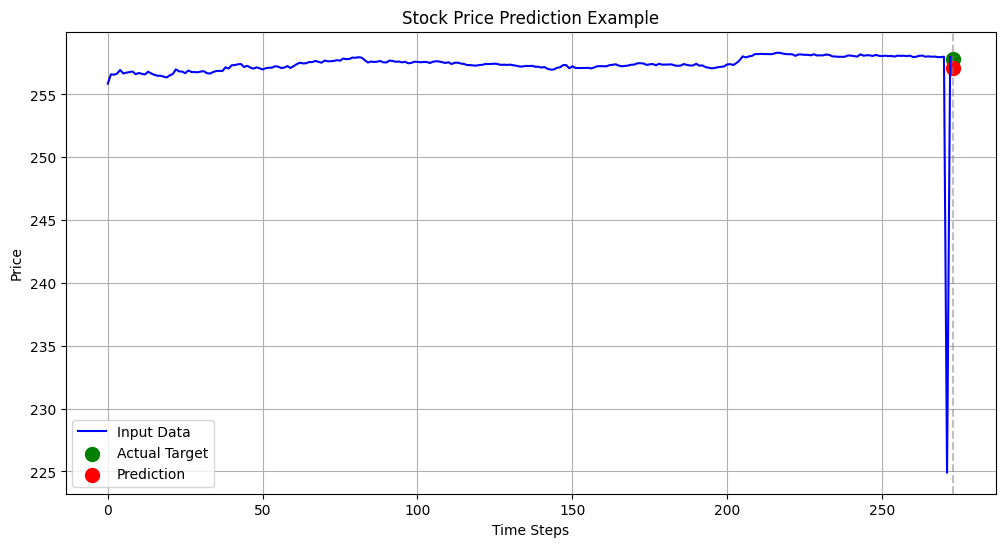

In [4]:
import matplotlib.pyplot as plt

# Get one batch from test loader
test_inputs, test_targets = next(iter(test_loader))

# Get prediction for this batch
model.eval()
with torch.no_grad():
    predictions = model(test_inputs)

# Convert to numpy for plotting
sample_idx = 0  # Take the first example from the batch
input_data = test_inputs[sample_idx].numpy()
target = test_targets[sample_idx].numpy()
prediction = predictions[sample_idx].numpy()

# Create time points for x-axis
time_points = np.arange(len(input_data))
prediction_time = len(input_data)  # The prediction is made for this time point

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time_points, input_data, 'b-', label='Input Data')
plt.scatter(prediction_time, target, color='g', label='Actual Target', s=100)
plt.scatter(prediction_time, prediction, color='r', label='Prediction', s=100)
plt.axvline(x=prediction_time, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.title('Stock Price Prediction Example')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.grid(True)
plt.show()